In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt 

data=pd.read_csv("GercekZamanliTuketim-01012016-01122020.csv", encoding ="ISO-8859-1")
data=data.apply(lambda x: x.str.replace('.',''))
data=data.apply(lambda x: x.str.replace(',','.'))
data['Tüketim Miktarý (MWh)'] = data['Tüketim Miktarý (MWh)'].astype(float)
data.insert(0,'Index',range(0,len(data)))
#data.drop(data.loc[data['Tarih']=='27032016'].index, inplace=True)

##Lag_168
lag_168_index=data[168:]['Index']-168
lag_168=data[data['Index'].isin(lag_168_index)]['Tüketim Miktarý (MWh)']


##Lag_48
lag_48_index=data[168:]['Index']-48
lag_48=data[data['Index'].isin(lag_48_index)]['Tüketim Miktarý (MWh)'].to_frame()
lag_48.reset_index(inplace = True)

column_names = ["Date", "Hour", "Lag_48","Lag_168","Consumption"]
df = pd.DataFrame(columns = column_names)
df['Date']=data.iloc[168:,1]
df['Hour']=data.iloc[168:,2]
df['Consumption']=data.iloc[168:,3]
df.reset_index(inplace = True) 
df['Lag_168']=lag_168
df['Lag_48']=lag_48.loc[:,'Tüketim Miktarý (MWh)']

df.drop(df.loc[df['Date']=='27032016'].index, inplace=True)
df.drop(df.loc[df['Date']=='29032016'].index, inplace=True)
df.drop(df.loc[df['Date']=='03042016'].index, inplace=True)
df

,index,Date,Hour,Lag_48,Lag_168,Consumption
0,168,08012016,0:00,29189.27,26277.24,28602.02
1,169,08012016,1:00,27614.02,24991.82,27112.37
2,170,08012016,2:00,26578.97,23532.61,25975.34
3,171,08012016,3:00,25719.19,22464.78,25315.55
4,172,08012016,4:00,25864.63,22002.91,25128.15
...,...,...,...,...,...,...
42955,43123,01122020,19:00,36310.77,40895.17,40720.16
42956,43124,01122020,20:00,35383.08,39240.65,39195.74
42957,43125,01122020,21:00,34491.45,38366.41,38310.79
42958,43126,01122020,22:00,33698.14,37446.73,37173.97


I again represented the data in the long format. And I removed 3 dates (27.03.2016, 29.03.2016 and 03.04.2016) from the data since there is a misleading hour consumption value on 27.03.2016 as in part b.

In [4]:
features=['Lag_48','Lag_168']
final_pred_df = pd.DataFrame()
thisdict={}
for i in range(0,24):
    hour_filtered_data=df[df['Hour']==str(i)+':00']
    starting_index_of_test_data=np.where(hour_filtered_data['Date']=='01112020')
    train_data=hour_filtered_data.iloc[0:starting_index_of_test_data[0][0],:]
    test_data=hour_filtered_data.iloc[starting_index_of_test_data[0][0]:,:]
    X_train = train_data.loc[:,features]
    X_test = test_data.loc[:,features]

    y_train = train_data.loc[:,'Consumption']
    y_test = test_data.loc[:,'Consumption']

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    pred = pd.DataFrame()
    pred['Date']=test_data.loc[:,'Date']
    pred['Hour']=test_data.loc[:,'Hour']
    pred['Consumption Prediction']=y_pred
    pred['Actual Consumption']=test_data.loc[:,'Consumption']
    final_pred_df=pd.concat([final_pred_df, pred], axis=0, sort=False)
final_pred_df

,Date,Hour,Consumption Prediction,Actual Consumption
42216,01112020,0:00,29398.567375,28701.62
42240,02112020,0:00,29200.203305,27931.36
42264,03112020,0:00,29773.503682,31301.07
42288,04112020,0:00,29232.487264,31278.36
42312,05112020,0:00,30423.508917,31494.01
...,...,...,...,...
42863,27112020,23:00,35422.677370,36119.57
42887,28112020,23:00,34814.783774,34500.14
42911,29112020,23:00,34025.004194,32295.74
42935,30112020,23:00,34905.089542,35775.04


To see whether hourly seasonality is important or not , I trained linear regression models for each hour. Firstly, I filtered each hour on the data and I splitted this filtered data into train and test data. Then I trained my model and I made predictions on the test data using the regression model. The actual and predicted consumption values for each day and hour can be seen in final_pred_df given above.

In [5]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print("MAPE: ",MAPE(final_pred_df['Actual Consumption'].to_numpy(),final_pred_df['Consumption Prediction'].to_numpy()))

MAPE:  4.360829306899345


Using the actual consumption and consumption predictions columns MAPE is found as 4.3608.

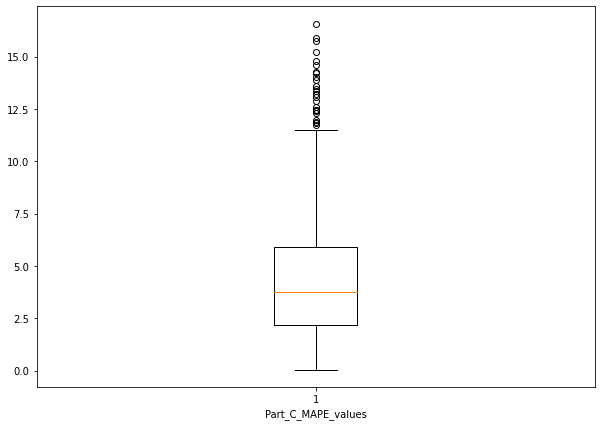

In [6]:
error=np.abs((final_pred_df['Actual Consumption'] - final_pred_df['Consumption Prediction'])/final_pred_df['Actual Consumption'])*100
fig = plt.figure(figsize =(10, 7)) 
plt.boxplot(error)
plt.xlabel('Part_C_MAPE_values')  
plt.show() 